### 本案例中所需要用到的数据来自于三星的 galaxy s3的加速器, 陀螺仪的数据, 包括: 走路, 站立, 躺下, 坐下和爬楼梯等等
### 我们需要只要有哪些活动类型, 我们尝试给予特征来对样本进行聚类后, 将确定身体活动的类型的问题进行分类

In [2]:
## 导入库
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn import metrics
from matplotlib import pyplot as plt
import os
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 图形参数设置修正
plt.rcParams['figure.figsize'] = [12, 9]
plt.rcParams['font.family'] = 'DejaVu sans'
plt.style.use('dark_background')

RANDOM_STATE = 17
import pandas as pd

In [4]:
# 加载并读取数据
!wget -nc "https://labfile.oss.aliyuncs.com/courses/1283/samsung_HAR.zip"
!unzip -o "samsung_HAR.zip"

--2025-06-08 14:51:07--  https://labfile.oss.aliyuncs.com/courses/1283/samsung_HAR.zip
Resolving labfile.oss.aliyuncs.com (labfile.oss.aliyuncs.com)... 47.110.177.159
Connecting to labfile.oss.aliyuncs.com (labfile.oss.aliyuncs.com)|47.110.177.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27939246 (27M) [application/zip]
Saving to: 'samsung_HAR.zip'

     0K .......... .......... .......... .......... ..........  0% 7.15M 4s
    50K .......... .......... .......... .......... ..........  0% 1.13M 14s
   100K .......... .......... .......... .......... ..........  0% 1.21M 16s
   150K .......... .......... .......... .......... ..........  0% 4.49M 14s
   200K .......... .......... .......... .......... ..........  0% 1.63M 14s
   250K .......... .......... .......... .......... ..........  1% 4.54M 13s
   300K .......... .......... .......... .......... ..........  1% 9.25M 11s
   350K .......... .......... .......... .......... ..........  1% 5.59M 10s


Archive:  samsung_HAR.zip
   creating: samsung_HAR/
  inflating: samsung_HAR/samsung_test_labels.txt  
  inflating: samsung_HAR/samsung_train_labels.txt  
  inflating: samsung_HAR/samsung_test.txt  
  inflating: samsung_HAR/samsung_train.txt  


In [6]:
# 加载并读取数据
PATH_TO_SAMSUMG_DATA= './samsung_HAR'
X_train = np.loadtxt(os.path.join(PATH_TO_SAMSUMG_DATA, 'samsung_train.txt'))
y_train = np.loadtxt(os.path.join(PATH_TO_SAMSUMG_DATA, 'samsung_train_labels.txt'))
X_test = np.loadtxt(os.path.join(PATH_TO_SAMSUMG_DATA, 'samsung_test.txt'))
y_test = np.loadtxt(os.path.join(PATH_TO_SAMSUMG_DATA, 'samsung_test_labels.txt'))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7352, 561), (2947, 561), (7352,), (2947,))

In [7]:
# 因为没有目标向量, 所以, 我们合并训练和测试样本
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])
X.shape, y.shape

((10299, 561), (10299,))

In [16]:
# 我们尝试查看类别数据中唯一的值有哪些, 并得到数据集目标类别的数量
np.unique(y)
n_calsses = np.unique(y).size

In [10]:
# 使用完成特征的数据的规范化: StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled.shape

(10299, 561)

In [11]:
# 应用主成分分析PCA降维来缩减特征的数量
pca = PCA(n_components=0.9, random_state=17).fit(X_scaled)
X_pca = pca.transform(X_scaled)
X_pca.shape

(10299, 65)

In [13]:
# 降维后的第一主成分覆盖的比例为 51
round(float(pca.explained_variance_ratio_[0]*100))

51

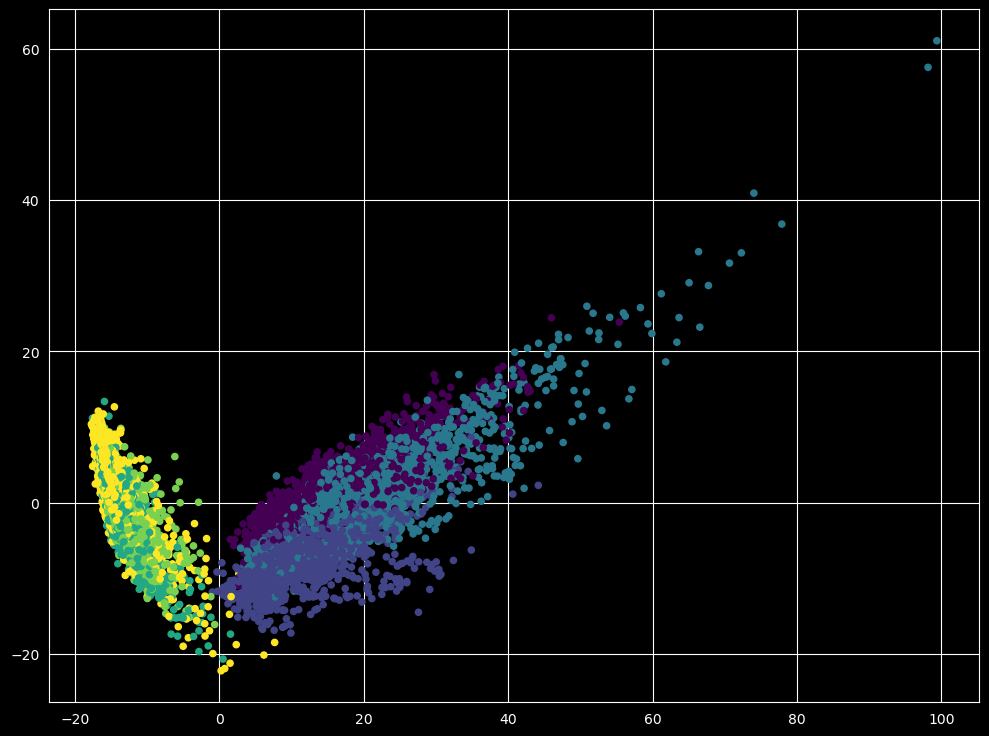

In [14]:
# 绘制前两个主成分的二维散点图, 并用数据一直类别进行着色
plt.scatter(X_pca[:,0], X_pca[:,1],c=y,s=20,cmap='viridis')
plt.show()

In [22]:
# 从以上的散点图来看, 可以看出总共分为两个簇
# 使用kmeans 聚类方法对PCA降维后的数据进行聚类操作
kmeans = KMeans(n_clusters= n_calsses, n_init= 100, random_state = 17)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

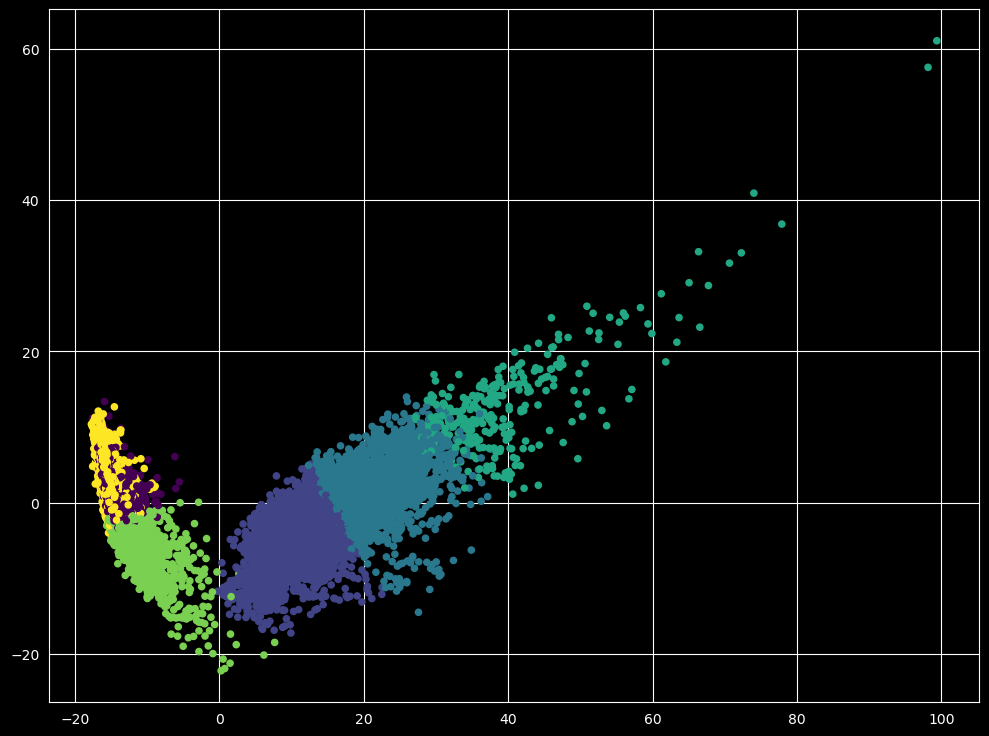

In [23]:
# 使用PCA前面的两个主要成分绘制二维图像, 使用kmeans聚类标签进行着色
plt.scatter(X_pca[:,0], X_pca[:,1],c=cluster_labels,s=20,cmap='viridis')
plt.show()

In [27]:
# 从上图可以看出原始数据标签分布和kmeans聚类标签的不同, 我们需要分别查看每个原始类别都被kmeans聚类划分为哪几个簇
tab = pd.crosstab(y, cluster_labels, margins = True)
tab.index = ['waking', 'going up', 'going down', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['cluster' + str(i+1) for i in range(6) ] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
waking,0,903,741,78,0,0,1722
going up,0,1241,296,5,2,0,1544
going down,0,320,890,196,0,0,1406
sitting,1235,1,0,0,450,91,1777
standing,1344,0,0,0,562,0,1906
laying,52,5,0,0,329,1558,1944
all,2631,2470,1927,279,1343,1649,10299


In [28]:
# 从上表中, 我们可以看出, 表格的行名称为原始标签, 列为聚类后的簇的序号, 几户所有的原始的数据都被重新聚类为几个风扇的簇

In [30]:
# 计算原始类别聚类的风扇程度, 并按照风扇程度由大到小进行排序
pd.Series(tab.iloc[:-1, :-1].max(axis = 1).values/
          tab.iloc[:-1, -1].values, index = tab.index[:-1]).sort_values

<bound method Series.sort_values of waking        0.524390
going up      0.803756
going down    0.633001
sitting       0.694992
standing      0.705142
laying        0.801440
dtype: float64>